<a href="https://colab.research.google.com/github/lkarjun/fastai-workouts/blob/master/Lesson_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package

In [2]:
!pip install fastai==2.5.3

     |████████████████████████████████| 189 kB 4.3 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
from fastai.vision.all import *

import fastai
fastai.__version__

'2.5.3'

# Convolutions

In [4]:
top_edge = tensor([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]]).float()

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)

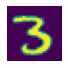

In [6]:
im3 = Image.open(path/'train/3/12.png')

show_image(im3);

In [7]:
im3_t = tensor(im3)

im3_t[0:3, 0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [8]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [9]:
df = pd.DataFrame(im3_t[3:10, :20])

df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
3,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
4,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
5,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [10]:
(im3_t[4:7,6:9] * top_edge).sum()

tensor(762.)

In [11]:
(im3_t[7:10,17:20] * top_edge).sum()

tensor(-29.)

In [12]:
def apply_kernel(row, col, kernel):
  transform = (im3_t[row-1: row+2, col-1:col+2]*kernel).sum()
  return transform

In [13]:
apply_kernel(5,7,top_edge)

tensor(762.)

In [14]:
# to get a grid of coordinates we can use a nested list comprehension

In [15]:
[[(i, j) for j in range(1, 5)] for i in range(1, 5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

In [16]:
rng = range(1, 27)

top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])

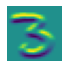

In [17]:
show_image(top_edge3);

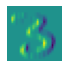

In [18]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()


left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

# Convolution in PyTorch

The reason for these extra axes is that PyTorch has a few tricks up its sleeve. The first trick is that PyTorch can apply a convolution to multiple images at the same time. That means we can call it on every item in a batch at once!

The second trick is that PyTorch can apply multiple kernels at the same time. So let's create the diagonal-edge kernels too, and then stack all four of our edge kernels into a single tensor:

In [19]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()


In [20]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [21]:
mnist = DataBlock(
            (ImageBlock(cls=PILImageBW), CategoryBlock),
            get_items = get_image_files,
            splitter = GrandparentSplitter(),
            get_y = parent_label      
          )

In [22]:
dls = mnist.dataloaders(path)

In [23]:
xb, yb = first(dls.valid)

xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [24]:
xb, yb = to_cpu(xb), to_cpu(yb)

We'll see how to handle more than one channel later in this chapter. Kernels passed to F.conv2d need to be rank-4 tensors: [channels_in, features_out, rows, columns]. edge_kernels is currently missing one of these. We need to tell PyTorch that the number of input channels in the kernel is one, which we can do by inserting an axis of size one (this is known as a unit axis) in the first location, where the PyTorch docs show in_channels is expected. To insert a unit axis into a tensor, we use the unsqueeze method:



In [25]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [26]:
edge_kernels = edge_kernels.unsqueeze(1)

In [27]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

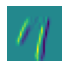

In [28]:
show_image(batch_features[0,0]);

## Strides and Padding

In an image of size h by w, using a padding of 1 and a stride of 2 will give us a result of size (h+1)//2 by (w+1)//2. The general formula for each dimension is (n + 2*pad - ks)//stride + 1, where pad is the padding, ks, the size of our kernel, and stride is the stride

In [29]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [30]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [31]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)

In [32]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [33]:
def conv(ni, nf, ks = 3, act = True):
  res = nn.Conv2d(ni, nf, stride = 2, kernel_size = ks, padding = ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

In [34]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

In [35]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [36]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [37]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [38]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.064771,0.027524,0.990186,00:17
1,0.018874,0.015670,0.995093,00:16


In [41]:
xb[0].shape

torch.Size([1, 28, 28])